In [2]:
%%capture
import re
import glob
from os import path
from datetime import datetime
import numpy as np

import geopandas as gpd
import fiona
import rioxarray as rxr
import xarray as xr
from shapely.geometry import mapping
from geocube.api.core import make_geocube
import cv2

from skimage.io import imread

import matplotlib.pyplot as plt


In [5]:
MASKS_PATH = '..\data\mask_per_year.gpkg'
IMAGES_PATH = '..\data\images'

grid = gpd.read_file('..\data\grid.gpkg')
years = fiona.listlayers(MASKS_PATH)[1:] # list layers/years

# read the masks 
mask_per_year = {key: gpd.read_file(MASKS_PATH, layer=key) for key in years}

# add a 1 column
for value in mask_per_year.values():
    value['value'] = 1

# CRS assertion 
for year in years:
    assert mask_per_year[year].crs == grid.crs, 'CRS must match'
assert grid.is_valid.all(), 'Invalid geometry'

# clip by grid extent 
mask_per_year = {key: values.clip(grid) for key, values in mask_per_year.items()}

In [6]:
paths = glob.glob(IMAGES_PATH +'/*')
paths

['..\\data\\images\\1942.tif',
 '..\\data\\images\\1962.tif',
 '..\\data\\images\\1971.tif',
 '..\\data\\images\\1979.tif',
 '..\\data\\images\\1983.tif',
 '..\\data\\images\\1984.tif',
 '..\\data\\images\\1992.tif',
 '..\\data\\images\\2002.tif']

In [35]:
def get_xarrays(paths):
    ''' Returns list of xarrays named by year '''
    imgs_by_year = {}
    print('Getting xarrays')
    for imgs in paths:
        print(imgs)
        # get the year name from the file path 
        year = re.findall(r"[\w+']+", imgs)[-2]

        # read rasters as xarrays
        xr_imgs = rxr.open_rasterio(imgs).squeeze().astype(np.uint8)

        # naming the xarrays by year
        xr_imgs.name = year

        # store list of xarrays
        imgs_by_year.update({year:xr_imgs})

    return imgs_by_year

# imgs_by_year = get_xarrays()

In [33]:
# years_ = list(imgs_by_year.keys())
# clipped_xarrays={}
# for year in years_:
#     print('clipping image from', imgs_by_year[year].name)
#     xr_imgs_clipped =  imgs_by_year[year].rio.clip(grid.geometry.apply(mapping), grid.crs)
#     clipped_xarrays.update({year:xr_imgs_clipped})

In [36]:
IMAGES_PATH = '..\data\clipped_images'
img_paths = glob.glob(IMAGES_PATH +'\*')

imgs_by_year = get_xarrays(img_paths)
    

Getting xarrays
..\data\clipped_images\1942.tif
..\data\clipped_images\1962.tif
..\data\clipped_images\1971.tif
..\data\clipped_images\1979.tif
..\data\clipped_images\1983.tif
..\data\clipped_images\1984.tif
..\data\clipped_images\1992.tif
..\data\clipped_images\2002.tif


In [ ]:
img_x = rxr.open_rasterio(img_paths[1]).squeeze().astype(np.uint8) 
img_h = rxr.open_rasterio(img_paths[0]).squeeze().astype(np.uint8) 

rose_interp = img_h.interp_like(img_x, method = 'cubic').astype(np.uint8) 

In [40]:
resize_to_1962_shpae = imgs_by_year['1962']

In [41]:
resize_to_1962_shpae = imgs_by_year['1962']
for year in imgs_by_year.keys():
    if year != '1962':
        rose_interp = imgs_by_year[year].interp_like(imgs_by_year['1962'], method = 'cubic').astype(np.uint8) 

        print(year)

1942
1971
1979
1983


MemoryError: Unable to allocate 7.77 GiB for an array with shape (28091, 37143) and data type float64

In [10]:
# {i.name:i.shape for i in imgs_by_year}

{'1942': (17504, 20480),
 '1962': (17564, 20480),
 '1971': (28316, 40288),
 '1979': (37310, 42010),
 '1983': (36058, 36332),
 '1984': (38860, 48306),
 '1992': (28368, 41014),
 '1996': (3, 35848, 49122),
 '2002': (35120, 36094)}

In [8]:
def clip_raster_to_mask_extent():
    # imgs_by_year = get_xarrays()
    clipped_xarrays=[]
    for xarray in imgs_by_year:
        print('clipping image from', xarray.name)

        # clip by grid extent 
        xr_imgs_clipped = xarray.rio.clip(grid.geometry.apply(mapping), grid.crs)
        clipped_xarrays.append(xr_imgs_clipped)
    return clipped_xarrays


In [14]:
IMAGES_PATH = '..\data\clipped_images'

img_paths = glob.glob(IMAGES_PATH +'\*')

In [16]:
def get_file_name(paths: list) -> list:
    ''' Returns file_name.tif'''
    return [img.split('\\')[-1].split('.')[0] for img in paths]

In [21]:
years = get_file_name(img_paths)

for path in img_paths:
     xr_imgs = rxr.open_rasterio(path).squeeze().astype(np.uint8)
     # try to overwrite the file 
    

In [ ]:
imgs_by_year = []
SIZES = []

for imgs in paths:
    # get the year name in the file path 
    year = re.findall(r"[\w+']+", imgs)[-2]

    xr_imgs = rxr.open_rasterio(imgs).squeeze().astype(np.uint8)
    
    # set time attributes 
    xr_imgs.attrs['year'] = year

    # store image sizes (may be used in a later stage to resample the raster)
    SIZES.append(xr_imgs.shape)
    SIZES.sort()

    # Save clipped raster
    if not path.exists(f"data/clipped_images/{year}.tif"):
        print('clipping image from', year)
        # clip by grid extent 
        xr_imgs_clipped = xr_imgs.rio.clip(grid.geometry.apply(mapping), grid.crs)

        # save geotif
        xr_imgs_clipped.rio.to_raster(f'data/clipped_images/{year}.tif')

    else:
        print(f'{year} is already clipped!')

clipping image from 1942


RasterioIOError: Attempt to create new tiff file 'data/clipped_images/1942.tif' failed: No such file or directory

In [ ]:
def rasterize_vect(df):
    return make_geocube(vector_data=df,
    measurements=["value"],
    resolution=(0.75,-0.75),
    fill=0).astype(np.uint8)
    
for year in years:
    # if not path.exists(f'../data/mask/{year}.tif'):
    dataset = rasterize_vect(mask_per_year[year])
    out_grid_2 = dataset.to_array()
    out_grid_3 = np.flip(np.squeeze(out_grid_2))
    out_grid_3.rio.to_raster(f'../data/mask/{year}.tif')

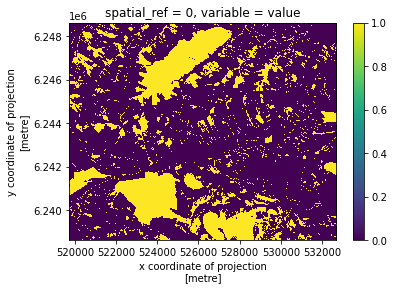

In [ ]:
out_grid_3.plot.imshow()

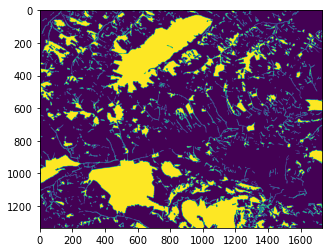

In [ ]:
plt.imshow(out_grid_3[::10,::10])

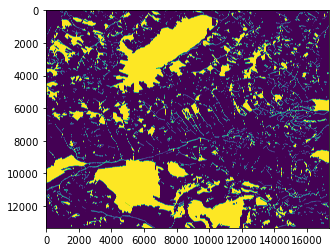

In [ ]:
img = imread('../data/mask/1942.tif')
plt.imshow(img)

TypeError: Invalid shape (1, 1334, 17335) for image data

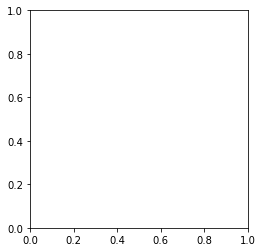

In [ ]:
plt.imshow(out_grid_2[::10,::10])


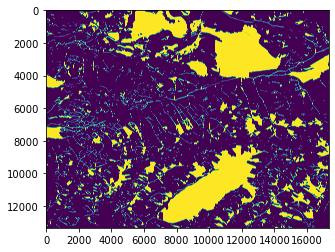

In [ ]:
plt.imshow(out_grid_2[0])